##**Determine whether the image is scenic or not from the image and the comment**##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = os.path.join('/content/drive/MyDrive/')

Mounted at /content/drive


Define the classifier : Must be the same as pretrained

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00


In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits

Read pretrained torch model

In [ ]:
import torch
model_path = '/content/drive/MyDrive/ViLT/scenic_model.pt'
classifier = ScenicClassifier(768)
classifier.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
classifier.eval()

ScenicClassifier(
  (embedding): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, 

Test on selected images

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files
from torchvision.io import read_image
import io
import torchvision

uploaded = files.upload()
img_resize = transforms.Resize((384, 512))
label = ['not scenic', 'scenic']

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

  # load the image and convert it to RGB
  uploaded[fn]
  img = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  comment = input("Enter the comment of the image : ")
  comment = comment.lower()
  encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)

  predict = classifier(encoding)
  print(label[torch.argmax(torch.squeeze(predict))])

KeyboardInterrupt: ignored

Test the finetuned model on validation and test dataset

In [ ]:
import pandas as pd
import os

path = '/content/drive/MyDrive/ViLT'
train_file = os.path.join(path, 'combined_train.csv')
val_file = os.path.join(path, 'combined_val.csv')
test_file = os.path.join(path, 'combined_test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import Resize
import torchvision
import numpy as np

class ViltDataset(Dataset):
  def __init__(self, dataframes):
    self.base_path = '/content/drive/MyDrive/ViLT'
    self.img_paths = dataframes['filename']
    self.comments = dataframes['clean_comments']
    self.resize = Resize((384, 512))
    self.labels = dataframes['scenic']

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = self.resize(read_image(os.path.join(self.base_path, img_path), mode=torchvision.io.ImageReadMode.RGB))
    comment = self.comments[idx]
    encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)
    label = torch.nn.functional.one_hot(torch.tensor(self.labels[idx]), num_classes=2)

    return [encoding, label]

In [ ]:
# create dataloaders
# training_data = ViltDataset(train_df[:])
test_data = ViltDataset(test_df[:])
val_data = ViltDataset(val_df[:])

In [ ]:
# train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True)

In [ ]:
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = 'cpu'

def f1_score_eval(dataloader, dataname):
  correct = 0
  total = 0
  predicts = torch.zeros(0)
  groundtruth = torch.zeros(0)
  with torch.no_grad():
    for testdata in dataloader:
      encodings, labels = testdata
      encodings = encodings.to(device)
      for key in encodings.keys():
        encodings[key] = torch.squeeze(encodings[key], 1)
      output = classifier(encodings)
      _, predicted = torch.max(output.data, 1)
      # print(predicts)
      # print(torch.argmax(labels.to('cpu'), 1))
      predicts = torch.cat((predicts, predicted), 0)
      total+= labels.size(0)
      groundtruth = torch.cat((groundtruth, labels.to('cpu')), 0)
      correct+=(predicted.to('cpu')==torch.argmax(labels.to('cpu'), 1)).sum().item()

  print(f'Accuracy of the network on {dataname} images : {100*correct//total}%')

  # draw confusion matrix
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
  predicts = torch.tensor(predicts[:], dtype=torch.int)
  conf_mat = confusion_matrix(groundtruth.numpy(), predicts.numpy())

  print(classification_report(groundtruth, predicts))
  plt.figure(figsize=(10,7))
  sns.heatmap(conf_mat, annot=True, cmap='Blues')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(dataname)
  plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on validation images : 95%
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.92      0.96        12

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



<ipython-input-13-66ab96cee086>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
<ipython-input-13-66ab96cee086>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int)


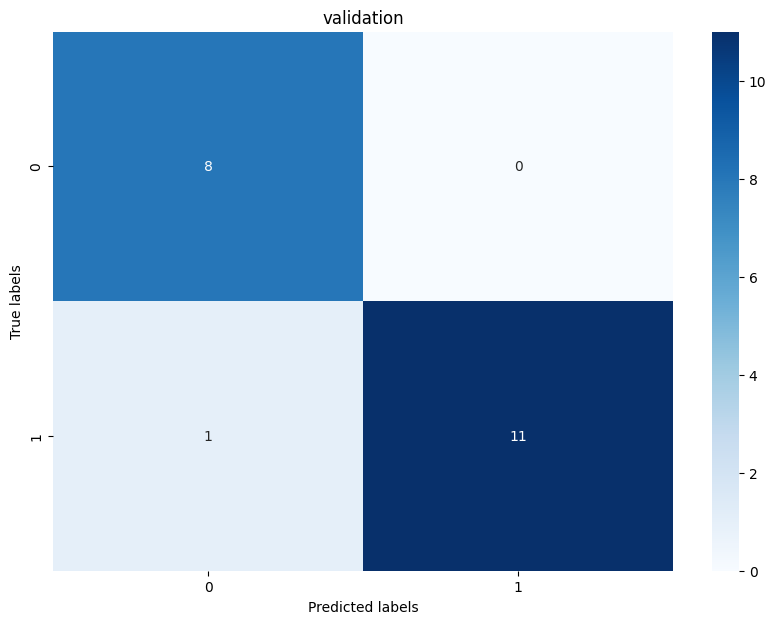

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on test images : 100%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<ipython-input-13-66ab96cee086>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruth = torch.tensor(groundtruth[:,1], dtype=torch.int)
<ipython-input-13-66ab96cee086>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = torch.tensor(predicts[:], dtype=torch.int)


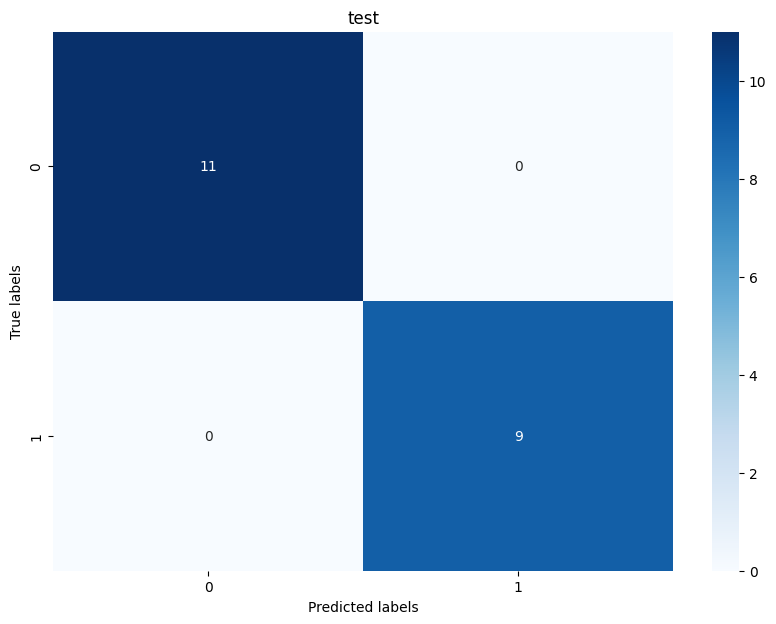

In [ ]:
f1_score_eval(val_dataloader, 'validation')
f1_score_eval(test_dataloader, 'test')